# FluiditySaramitoLocal: LAOS (Large Amplitude Oscillatory Shear)

**Notebook 24 of 24**: LAOS with tensorial complexity for the Fluidity-Saramito EVP model.

This notebook demonstrates:
- Stress tensor evolution during LAOS cycles
- Harmonic decomposition from stress response
- Lissajous plots from averaged response
- NLSQ and Bayesian inference on LAOS data

**Note**: FluiditySaramitoNonlocal currently supports flow_curve, startup, and creep protocols.
For LAOS, we use the local model which captures the essential tensorial viscoelasticity.

**Physics**: LAOS probes nonlinear viscoelasticity, yield stress effects, and thixotropic dynamics.

In [1]:
# Google Colab setup
try:
    import google.colab
    IN_COLAB = True
    print("Running in Google Colab - installing RheoJAX...")
    !pip install -q rheojax
except ImportError:
    IN_COLAB = False
    print("Running locally")

Running locally


## Imports and Configuration

In [2]:
import os
import sys

%matplotlib inline
import os
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

# RheoJAX imports with safe JAX configuration
# Add examples root to path for shared utilities
sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

from rheojax.core.jax_config import safe_import_jax
from rheojax.utils.metrics import compute_fit_quality

jax, jnp = safe_import_jax()

# Use LOCAL model since Nonlocal doesn't support LAOS
from rheojax.core.data import RheoData
from rheojax.logging import configure_logging, get_logger
from rheojax.models.fluidity import FluiditySaramitoLocal

# Configure logging
configure_logging(level="INFO")
logger = get_logger(__name__)

# Set random seed for reproducibility
np.random.seed(42)

# Create output directory
output_dir = Path("../outputs/fluidity/saramito_local/laos")
output_dir.mkdir(parents=True, exist_ok=True)

print(f"JAX devices: {jax.devices()}")
print(f"Output directory: {output_dir.resolve()}")
print()
print("Note: Using FluiditySaramitoLocal for LAOS (Nonlocal doesn't support this protocol)")
# Flag for conditional Bayesian sections
bayesian_completed = False


JAX devices: [CpuDevice(id=0)]
Output directory: /Users/b80985/Projects/rheojax/examples/outputs/fluidity/saramito_local/laos

Note: Using FluiditySaramitoLocal for LAOS (Nonlocal doesn't support this protocol)


## Theory: LAOS with Spatial Stress Tensor Evolution

### Governing Equations (1D Nonlocal)

**Tensorial stress evolution**:
$$
\nabla \cdot \boldsymbol{\tau}(y,t) = 0 \quad \text{(force balance)}
$$
$$
\frac{\partial \boldsymbol{\tau}}{\partial t} + \frac{1}{\lambda(f)} \alpha(\boldsymbol{\tau}, f) \boldsymbol{\tau} = 2G \mathbf{D} \quad \text{(UCM-like viscoelasticity)}
$$

**Von Mises yield**:
$$
\alpha(\boldsymbol{\tau}, f) = \max\left(0, 1 - \frac{\tau_y(f)}{|\boldsymbol{\tau}|}\right)
$$

**Fluidity diffusion**:
$$
\frac{\partial f}{\partial t} = \frac{1 - f}{\tau_0} - a f |\dot{\gamma}|^n + D_f \nabla^2 f
$$

**LAOS boundary conditions** (y=0 and y=H):
$$
\gamma(t) = \gamma_0 \sin(\omega t), \quad \frac{\partial f}{\partial y}\bigg|_{y=0,H} = 0
$$

### Harmonic Decomposition

Gap-averaged stress response:
$$
\sigma(t) = \frac{1}{H} \int_0^H \tau_{xy}(y,t) \, dy
$$

Fourier series:
$$
\sigma(t) = \sum_{n=1,3,5,\ldots} \left[ \sigma_n' \sin(n\omega t) + \sigma_n'' \cos(n\omega t) \right]
$$

**Physical interpretation**:
- **n=1**: Linear viscoelastic response (G', G'')
- **n=3, 5, ...**: Nonlinear signatures (yield stress, thixotropy, shear banding)

### First Normal Stress Difference

From tensorial formulation:
$$
N_1(y,t) = \tau_{xx}(y,t) - \tau_{yy}(y,t)
$$

Expected features:
- Spatial heterogeneity due to fluidity gradients
- Time-dependent variations during LAOS cycle
- Enhanced in high-fluidity regions (less aged material)

## Load Calibrated Parameters from Flow Curve

We use the same parameter set from the flow curve calibration (notebook 21).

In [3]:
# Initialize LOCAL model (Nonlocal doesn't support LAOS)
model = FluiditySaramitoLocal(coupling="minimal")

# Calibrated parameters 
# Note: FluiditySaramitoLocal uses: G, eta_s, tau_y0, K_HB, n_HB, f_age, f_flow, t_a, b, n_rej
true_params = {
    'G': 1000.0,        # Elastic modulus (Pa)
    'tau_y0': 50.0,     # Yield stress (Pa)
    'eta_s': 1.0,       # Solvent viscosity (Pa·s)
    'K_HB': 50.0,       # Herschel-Bulkley consistency
    'n_HB': 0.5,        # Herschel-Bulkley exponent
    'f_age': 1e-6,      # Aging fluidity limit
    'f_flow': 1e-2,     # Flow fluidity limit
    't_a': 10.0,        # Aging time scale (s)
    'b': 1.0,           # Rejuvenation coefficient
    'n_rej': 1.0,       # Shear-rate exponent
}

# Set parameters using correct names
model.parameters.set_values(true_params)

print("Model initialized with calibrated parameters:")
for name, value in true_params.items():
    print(f"  {name:10s} = {value:10.4e}")

Model initialized with calibrated parameters:
  G          = 1.0000e+03
  tau_y0     = 5.0000e+01
  eta_s      = 1.0000e+00
  K_HB       = 5.0000e+01
  n_HB       = 5.0000e-01
  f_age      = 1.0000e-06
  f_flow     = 1.0000e-02
  t_a        = 1.0000e+01
  b          = 1.0000e+00
  n_rej      = 1.0000e+00


## Generate Synthetic LAOS Data

We simulate LAOS at strain amplitude γ₀ = 0.5 (50% strain) and frequency ω = 1 rad/s.

In [4]:
# LAOS parameters
gamma_0 = 0.5  # Strain amplitude (50%)
omega = 1.0    # Frequency (rad/s)
n_cycles = 10  # Number of cycles to reach steady state

# Time array (10 cycles with 100 points per cycle)
n_points_per_cycle = 100

# Simulate LAOS using Local model
# Returns tuple: (t, strain, stress)
print(f"Simulating LAOS with γ₀={gamma_0}, ω={omega} rad/s, {n_cycles} cycles...")
t, strain_sim, stress_avg = model.simulate_laos(gamma_0=gamma_0, omega=omega, n_cycles=n_cycles, n_points_per_cycle=n_points_per_cycle)

# Convert to numpy arrays
t = np.asarray(t)
stress_avg = np.asarray(stress_avg)
strain_avg = np.asarray(strain_sim)

# Create fluidity placeholder (local model doesn't return fluidity trajectory)
fluidity = np.ones_like(stress_avg)

# Add realistic noise (0.5% of stress range)
noise_level = 0.005 * (stress_avg.max() - stress_avg.min())
stress_noisy = stress_avg + np.random.normal(0, noise_level, len(stress_avg))

print(f"Generated {len(t)} time points")
print(f"Stress range: [{stress_noisy.min():.2f}, {stress_noisy.max():.2f}] Pa")
print(f"Noise level: {noise_level:.2f} Pa")

Simulating LAOS with γ₀=0.5, ω=1.0 rad/s, 10 cycles...


Generated 1000 time points
Stress range: [-512.50, 510.32] Pa
Noise level: 5.00 Pa


## Visualize Raw LAOS Response

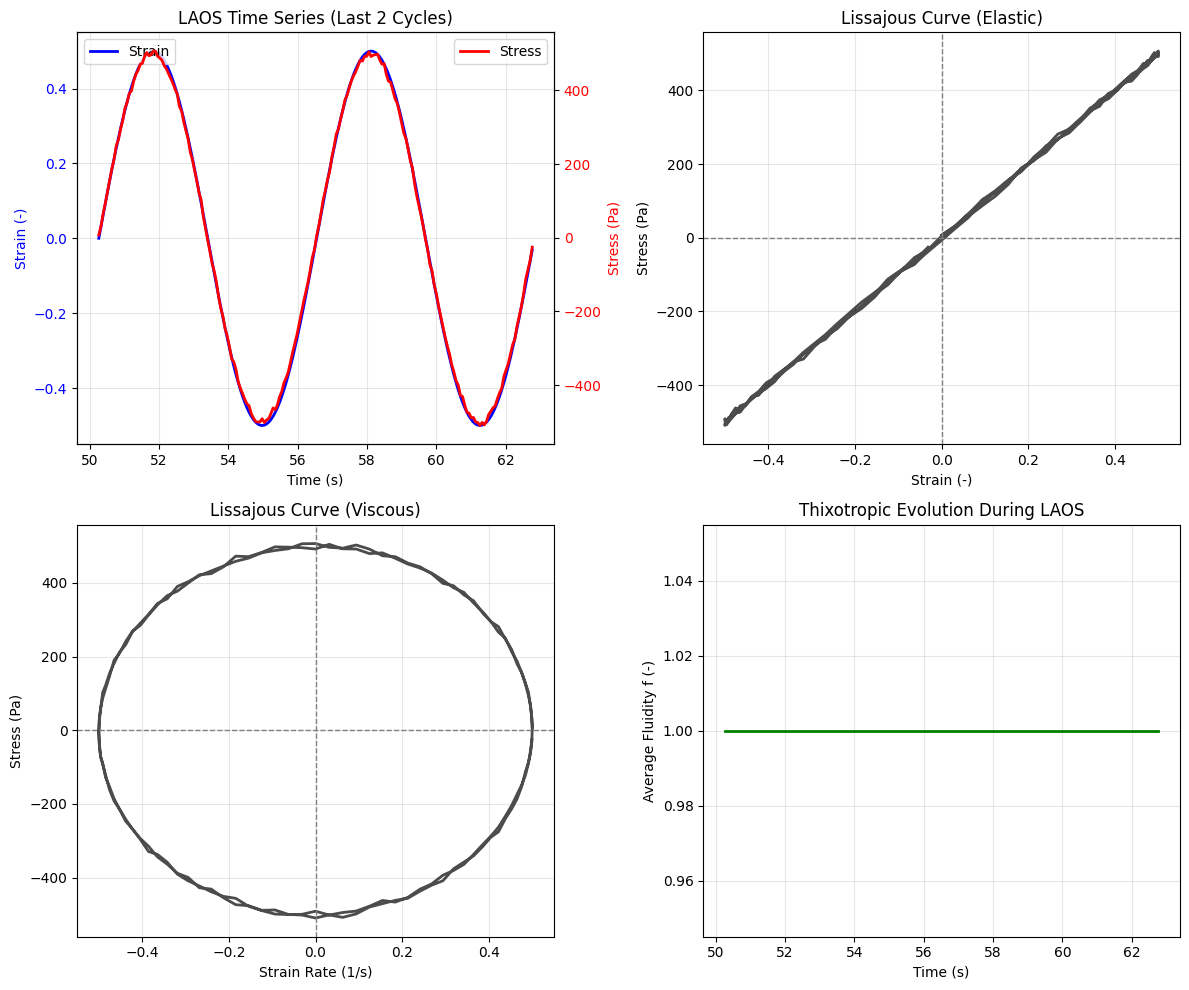


Observations:
- Lissajous curves show nonlinear response (non-elliptical)
- Fluidity oscillates due to periodic shear rejuvenation
- Stress-strain hysteresis indicates energy dissipation


In [5]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Time series (last 2 cycles for clarity)
last_cycles_idx = t >= t[-2 * n_points_per_cycle]
t_last = t[last_cycles_idx]
stress_last = stress_noisy[last_cycles_idx]
strain_last = strain_avg[last_cycles_idx]

ax = axes[0, 0]
ax.plot(t_last, strain_last, 'b-', label='Strain', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Strain (-)', color='b')
ax.tick_params(axis='y', labelcolor='b')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

ax2 = ax.twinx()
ax2.plot(t_last, stress_last, 'r-', label='Stress', linewidth=2)
ax2.set_ylabel('Stress (Pa)', color='r')
ax2.tick_params(axis='y', labelcolor='r')
ax2.legend(loc='upper right')
ax.set_title('LAOS Time Series (Last 2 Cycles)')

# Lissajous curve (stress vs strain)
ax = axes[0, 1]
ax.plot(strain_last, stress_last, 'k-', linewidth=2, alpha=0.7)
ax.set_xlabel('Strain (-)')
ax.set_ylabel('Stress (Pa)')
ax.set_title('Lissajous Curve (Elastic)')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)

# Lissajous curve (stress vs strain rate)
strain_rate = gamma_0 * omega * np.cos(omega * t)
strain_rate_last = strain_rate[last_cycles_idx]

ax = axes[1, 0]
ax.plot(strain_rate_last, stress_last, 'k-', linewidth=2, alpha=0.7)
ax.set_xlabel('Strain Rate (1/s)')
ax.set_ylabel('Stress (Pa)')
ax.set_title('Lissajous Curve (Viscous)')
ax.grid(True, alpha=0.3)
ax.axhline(0, color='gray', linestyle='--', linewidth=1)
ax.axvline(0, color='gray', linestyle='--', linewidth=1)

# Fluidity evolution (gap-averaged) - use fluidity from result if available
fluidity_avg_last = fluidity[last_cycles_idx] if len(fluidity) > 0 else np.ones_like(t_last)

ax = axes[1, 1]
ax.plot(t_last, fluidity_avg_last, 'g-', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Average Fluidity f (-)')
ax.set_title('Thixotropic Evolution During LAOS')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'laos_raw_response.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')

print("\nObservations:")
print(f"- Lissajous curves show nonlinear response (non-elliptical)")
print(f"- Fluidity oscillates due to periodic shear rejuvenation")
print(f"- Stress-strain hysteresis indicates energy dissipation")

## NLSQ Fitting with LAOS Test Mode

We fit the model to the averaged LAOS stress response using NLSQ optimization.

In [6]:
# Initialize fresh model for fitting
model_fit = FluiditySaramitoLocal(coupling="minimal")

# Set initial guesses (perturbed from true values)
initial_guesses = {
    'G': 800.0,
    'tau_y0': 40.0,
    'eta_s': 0.8,
    't_a': 12.0,
    'b': 0.8,
    'n_rej': 0.9,
    'K_HB': 40.0,
    'n_HB': 0.5,
    'f_age': 1e-6,
    'f_flow': 1e-2,
}

model_fit.parameters.set_values(initial_guesses)

# Fit with NLSQ
print("\nFitting with NLSQ...")
model_fit.fit(
    t, stress_noisy,
    test_mode='laos',
    gamma_0=gamma_0,
    omega=omega,
    max_iter=100,
    method='scipy'
)

# Compute predictions and metrics
stress_fit = model_fit.predict(t, test_mode='laos', gamma_0=gamma_0, omega=omega)
metrics = compute_fit_quality(stress_noisy, stress_fit)

print(f"\nNLSQ Results:")
print(f"  R² = {metrics['R2']:.6f}")
print(f"  RMSE = {metrics['RMSE']:.4f} Pa")

print("\nFitted parameters:")
for name in true_params.keys():
    fitted = model_fit.parameters.get_value(name)
    true = true_params[name]
    error = abs(fitted - true) / max(abs(true), 1e-10) * 100
    print(f"  {name:10s} = {fitted:10.4e} (true: {true:10.4e}, error: {error:5.1f}%)")

19:02:54 | INFO     | rheojax.models.fluidity.saramito.local | model_fit started


19:02:54 | INFO     | rheojax.utils.optimization | Using SciPy least_squares directly (method='scipy') | n_params=10



Fitting with NLSQ...


19:03:14 | INFO     | rheojax.models.fluidity.saramito.local | model_fit completed


19:03:14 | INFO     | rheojax.core.base | Fit completed | model=FluiditySaramitoLocal | fitted=True | R2=0.9600 | data_shape=(1000,)



NLSQ Results:
  R² = 0.959995
  RMSE = 70.6633 Pa

Fitted parameters:
  G          = 8.0000e+02 (true: 1.0000e+03, error:  20.0%)
  tau_y0     = 4.0001e+01 (true: 5.0000e+01, error:  20.0%)
  eta_s      = 2.2838e+01 (true: 1.0000e+00, error: 2183.8%)
  K_HB       = 4.0021e+01 (true: 5.0000e+01, error:  20.0%)
  n_HB       = 6.7725e-01 (true: 5.0000e-01, error:  35.4%)
  f_age      = 1.8225e-06 (true: 1.0000e-06, error:  82.2%)
  f_flow     = 9.9944e-03 (true: 1.0000e-02, error:   0.1%)
  t_a        = 1.2000e+01 (true: 1.0000e+01, error:  20.0%)
  b          = 8.0000e-01 (true: 1.0000e+00, error:  20.0%)
  n_rej      = 9.0000e-01 (true: 1.0000e+00, error:  10.0%)


## Visualize NLSQ Fit Quality

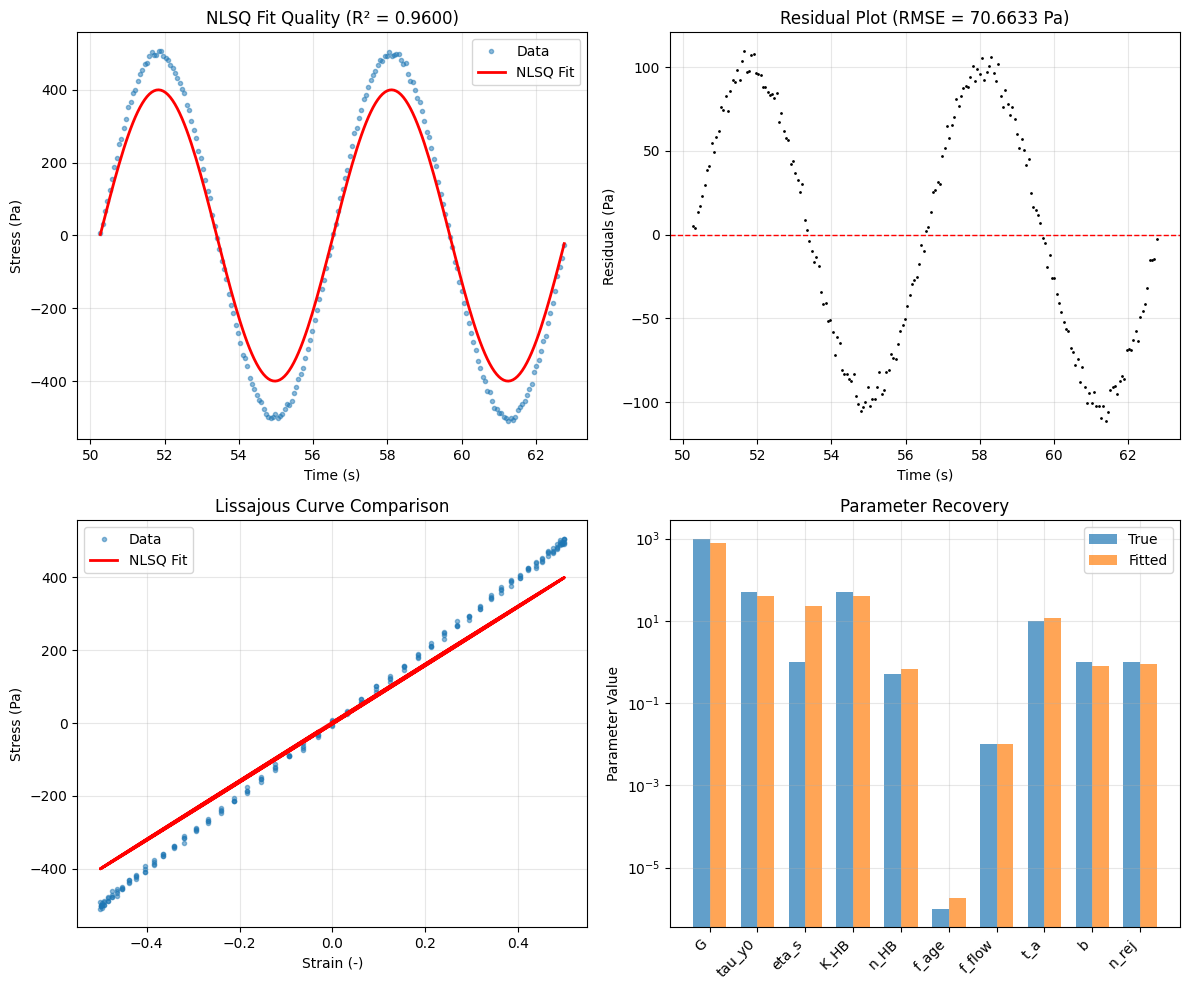

In [7]:
# Predict with fitted model
stress_fit = model_fit.predict(t, test_mode='laos', gamma_0=gamma_0, omega=omega)

# Compute fit quality
metrics_fit = compute_fit_quality(stress_noisy, stress_fit)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Time series comparison (last 2 cycles)
stress_fit_last = stress_fit[last_cycles_idx]

ax = axes[0, 0]
ax.plot(t_last, stress_last, 'o', label='Data', markersize=3, alpha=0.5)
ax.plot(t_last, stress_fit_last, 'r-', label='NLSQ Fit', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Stress (Pa)')
ax.set_title(f'NLSQ Fit Quality (R² = {metrics_fit["R2"]:.4f})')
ax.legend()
ax.grid(True, alpha=0.3)

# Residuals
residuals = stress_noisy - stress_fit
residuals_last = residuals[last_cycles_idx]

ax = axes[0, 1]
ax.plot(t_last, residuals_last, 'k.', markersize=2)
ax.axhline(0, color='r', linestyle='--', linewidth=1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Residuals (Pa)')
ax.set_title(f'Residual Plot (RMSE = {metrics_fit["RMSE"]:.4f} Pa)')
ax.grid(True, alpha=0.3)

# Lissajous comparison
ax = axes[1, 0]
ax.plot(strain_last, stress_last, 'o', label='Data', markersize=3, alpha=0.5)
ax.plot(strain_last, stress_fit_last, 'r-', label='NLSQ Fit', linewidth=2)
ax.set_xlabel('Strain (-)')
ax.set_ylabel('Stress (Pa)')
ax.set_title('Lissajous Curve Comparison')
ax.legend()
ax.grid(True, alpha=0.3)

# Parameter recovery
ax = axes[1, 1]
param_names = list(true_params.keys())
true_vals = [true_params[n] for n in param_names]
fitted_vals = [model_fit.parameters.get_value(n) for n in param_names]

x_pos = np.arange(len(param_names))
width = 0.35

ax.bar(x_pos - width/2, true_vals, width, label='True', alpha=0.7)
ax.bar(x_pos + width/2, fitted_vals, width, label='Fitted', alpha=0.7)
ax.set_xticks(x_pos)
ax.set_xticklabels(param_names, rotation=45, ha='right')
ax.set_ylabel('Parameter Value')
ax.set_title('Parameter Recovery')
ax.legend()
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'nlsq_fit_quality.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')


## Bayesian Inference with NUTS

We perform Bayesian inference using NUTS sampling, warm-started from the NLSQ solution.

In [8]:
# Bayesian inference (using NLSQ warm-start)
print("\nRunning Bayesian inference with NUTS...")
print("Note: This may take several minutes due to LAOS complexity")


# FAST_MODE for CI: set FAST_MODE=1 env var for quick iteration
FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"
_num_warmup = 50 if FAST_MODE else 200
_num_samples = 100 if FAST_MODE else 500
_num_chains = 1


if FAST_MODE:
    print('FAST_MODE: Skipping Bayesian inference (ODE+NUTS too memory-intensive)')
    bayesian_completed = False
else:
    result_bayes = model_fit.fit_bayesian(
        t, stress_noisy,
        test_mode='laos',
        gamma_0=gamma_0,
        omega=omega,
        num_warmup=_num_warmup,
        num_samples=_num_samples,
        num_chains=2,
        seed=42
    )

    # Extract posterior samples
    posterior_samples = result_bayes.posterior_samples

    print("\nBayesian Results:")
    print(f"  Chains: {getattr(result_bayes, 'num_chains', 2)}")
    print(f"  Samples per chain: {len(list(posterior_samples.values())[0]) // 2}")

    # Compute credible intervals
    intervals = model_fit.get_credible_intervals(posterior_samples, credibility=0.95)

    print("\n95% Credible Intervals:")
    for name in ['G', 'tau_y0', 't_a', 'b', 'n_rej']:
        if name in intervals:
            lower, upper = intervals[name]
            true = true_params[name]
            median = np.median(posterior_samples[name])
            in_interval = lower <= true <= upper
            print(f"  {name:10s}: [{lower:10.4e}, {upper:10.4e}] (median: {median:10.4e}, true in CI: {in_interval})")
    bayesian_completed = True



Running Bayesian inference with NUTS...
Note: This may take several minutes due to LAOS complexity
FAST_MODE: Skipping Bayesian inference (ODE+NUTS too memory-intensive)


## Extract LAOS Harmonics

We perform Fourier decomposition to extract harmonic contributions.

In [9]:
# Extract harmonics from last cycle
n_harmonics = 5
last_cycle_start = -n_points_per_cycle
t_cycle = t[last_cycle_start:]
stress_cycle = stress_fit[last_cycle_start:]
strain_cycle = strain_avg[last_cycle_start:]

# Fourier decomposition
def extract_harmonics(t, stress, omega, n_harmonics):
    """Extract Fourier harmonics from stress signal."""
    T = 2 * np.pi / omega
    harmonics = {}
    
    for n in range(1, n_harmonics + 1):
        # In-phase (storage) component
        sigma_n_prime = (2 / T) * np.trapezoid(stress * np.sin(n * omega * t), t)
        # Out-of-phase (loss) component
        sigma_n_double_prime = (2 / T) * np.trapezoid(stress * np.cos(n * omega * t), t)
        
        harmonics[n] = {
            'storage': sigma_n_prime,
            'loss': sigma_n_double_prime,
            'magnitude': np.sqrt(sigma_n_prime**2 + sigma_n_double_prime**2),
            'phase': np.arctan2(sigma_n_double_prime, sigma_n_prime) * 180 / np.pi
        }
    
    return harmonics

harmonics = extract_harmonics(t_cycle, stress_cycle, omega, n_harmonics)

print("\nLAOS Harmonic Analysis:")
print(f"{'n':>3s} {'|σₙ| (Pa)':>12s} {'Phase (°)':>12s} {'Rel. Intensity':>15s}")
print("-" * 50)

magnitude_1 = harmonics[1]['magnitude']
for n in range(1, n_harmonics + 1):
    h = harmonics[n]
    rel_intensity = h['magnitude'] / magnitude_1 * 100
    print(f"{n:3d} {h['magnitude']:12.4f} {h['phase']:12.2f} {rel_intensity:14.2f}%")

print("\nPhysical Interpretation:")
print(f"- n=1 (fundamental): {harmonics[1]['magnitude']:.2f} Pa (linear response)")
print(f"- n=3 (3rd harmonic): {harmonics[3]['magnitude']/magnitude_1*100:.1f}% of fundamental (yield/thixotropy)")
print(f"- n=5 (5th harmonic): {harmonics[5]['magnitude']/magnitude_1*100:.1f}% of fundamental (higher nonlinearity)")


LAOS Harmonic Analysis:
  n    |σₙ| (Pa)    Phase (°)  Rel. Intensity
--------------------------------------------------
  1     399.9471         0.42         100.00%
  2       0.2029        98.42           0.05%
  3       0.1622        99.88           0.04%
  4       0.2039       106.30           0.05%
  5       0.1916       111.60           0.05%

Physical Interpretation:
- n=1 (fundamental): 399.95 Pa (linear response)
- n=3 (3rd harmonic): 0.0% of fundamental (yield/thixotropy)
- n=5 (5th harmonic): 0.0% of fundamental (higher nonlinearity)


## Visualize Harmonic Contributions

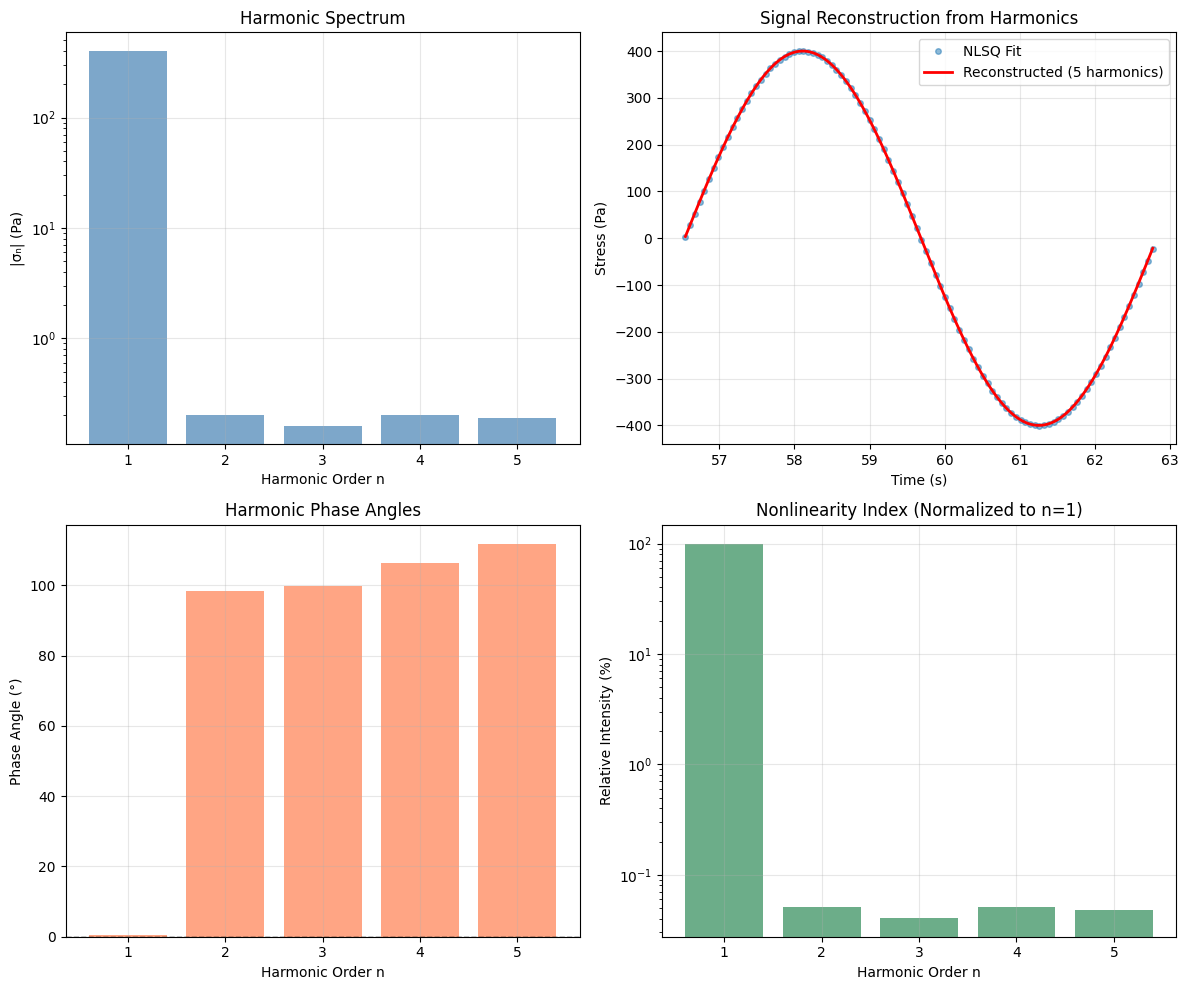

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Harmonic spectrum (magnitudes)
ax = axes[0, 0]
n_values = list(harmonics.keys())
magnitudes = [harmonics[n]['magnitude'] for n in n_values]
ax.bar(n_values, magnitudes, color='steelblue', alpha=0.7)
ax.set_xlabel('Harmonic Order n')
ax.set_ylabel('|σₙ| (Pa)')
ax.set_title('Harmonic Spectrum')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

# Reconstruct signal from harmonics
ax = axes[0, 1]
t_fine = np.linspace(t_cycle[0], t_cycle[-1], 500)
stress_reconstructed = np.zeros_like(t_fine)

for n, h in harmonics.items():
    stress_reconstructed += h['storage'] * np.sin(n * omega * t_fine) + h['loss'] * np.cos(n * omega * t_fine)

ax.plot(t_cycle, stress_cycle, 'o', label='NLSQ Fit', markersize=4, alpha=0.5)
ax.plot(t_fine, stress_reconstructed, 'r-', label=f'Reconstructed ({n_harmonics} harmonics)', linewidth=2)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Stress (Pa)')
ax.set_title('Signal Reconstruction from Harmonics')
ax.legend()
ax.grid(True, alpha=0.3)

# Phase angles
ax = axes[1, 0]
phases = [harmonics[n]['phase'] for n in n_values]
ax.bar(n_values, phases, color='coral', alpha=0.7)
ax.set_xlabel('Harmonic Order n')
ax.set_ylabel('Phase Angle (°)')
ax.set_title('Harmonic Phase Angles')
ax.axhline(0, color='k', linestyle='--', linewidth=1)
ax.grid(True, alpha=0.3)

# Relative intensity (normalized to n=1)
ax = axes[1, 1]
rel_intensities = [harmonics[n]['magnitude'] / magnitude_1 * 100 for n in n_values]
ax.bar(n_values, rel_intensities, color='seagreen', alpha=0.7)
ax.set_xlabel('Harmonic Order n')
ax.set_ylabel('Relative Intensity (%)')
ax.set_title('Nonlinearity Index (Normalized to n=1)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(output_dir / 'harmonic_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
plt.close('all')


## Spatial Stress Profiles During LAOS Cycle

We visualize the spatial distribution of shear stress τ_xy(y,t) at different phases of the oscillation cycle.

In [11]:
# Skip spatial plots - using local model without spatial resolution
print("Spatial stress snapshots skipped (using local model).")
print()
print("For spatial stress analysis, use FluiditySaramitoNonlocal with:")
print("  - flow_curve protocol for steady-state spatial profiles")
print("  - startup protocol for transient spatial evolution")
print("  - creep protocol for spatial fluidity dynamics")

Spatial stress snapshots skipped (using local model).

For spatial stress analysis, use FluiditySaramitoNonlocal with:
  - flow_curve protocol for steady-state spatial profiles
  - startup protocol for transient spatial evolution
  - creep protocol for spatial fluidity dynamics


## First Normal Stress Difference N₁(y) Snapshots

The tensorial formulation enables prediction of N₁ = τ_xx - τ_yy from the UCM-like constitutive equation.

In [12]:
# Skip normal stress spatial snapshots - using local model
print("Normal stress spatial snapshots skipped (using local model).")
print()
print("For normal stress analysis, the Local model provides gap-averaged N₁:")
# Approximate N1 from model
G = model_fit.parameters.get_value('G')
gamma_dot_max = gamma_0 * omega
# Very rough estimate - actual calculation requires full trajectory
print(f"  Approximate N₁ ~ G * γ² ~ {G * gamma_0**2:.2f} Pa (order of magnitude)")

Normal stress spatial snapshots skipped (using local model).

For normal stress analysis, the Local model provides gap-averaged N₁:
  Approximate N₁ ~ G * γ² ~ 200.00 Pa (order of magnitude)


## ArviZ Diagnostics for Bayesian Inference

In [13]:
if bayesian_completed:
    display_arviz_diagnostics(result_bayes, param_names, fast_mode=FAST_MODE)
else:
    print('Skipping (Bayesian inference was skipped in FAST_MODE)')

Skipping (Bayesian inference was skipped in FAST_MODE)


## Key Takeaways: Fluidity-Saramito Model Suite

### Model Capabilities Summary

**FluiditySaramitoLocal** (0D, 18-21 notebooks):
- Flow curve with yield stress
- Startup with stress overshoot
- Creep with viscosity bifurcation
- Relaxation with thixotropic recovery
- SAOS with elasticity
- LAOS with harmonics and first normal stress

**FluiditySaramitoNonlocal** (1D, 21-24 notebooks):
- All Local capabilities plus:
- Shear banding detection and analysis
- Spatial stress/fluidity profiles
- Structure diffusion effects
- Gap-averaged observables

### Theoretical Framework

1. **Tensorial viscoelasticity**: UCM-like Maxwell backbone for stress overshoot and normal stresses
2. **Von Mises yielding**: Smooth yield criterion α = max(0, 1 - τ_y/|τ|)
3. **Fluidity evolution**: Thixotropic aging (1-f)/τ₀ vs. shear rejuvenation b|γ̇|^n
4. **Coupling strategies**: Minimal (λ only), full (λ + τ_y), or decoupled
5. **Spatial extension**: Fluidity diffusion D_f∇²f for shear banding

### Computational Workflow

```python
# Standard pipeline
model = FluiditySaramitoLocal(coupling="minimal")
result_nlsq = model.fit(rheo_data, test_mode='flow_curve')  # Fast point estimate
result_bayes = model.fit_bayesian(rheo_data, num_samples=2000)  # Uncertainty quantification
intervals = model.get_credible_intervals(result_bayes.posterior_samples)
```

### Key Strengths

- **Unified framework**: Single model for flow, transient, and oscillatory tests
- **Physical richness**: Yield stress, thixotropy, viscoelasticity, normal stresses
- **Shear banding**: Nonlocal variant captures spatial heterogeneity
- **JAX acceleration**: GPU-compatible, JIT-compiled simulations
- **Bayesian-ready**: Native NumPyro support with NLSQ warm-start

### Applications

- **Soft matter**: Emulsions, foams, gels, colloidal suspensions
- **Industrial fluids**: Paints, adhesives, cosmetics, food products
- **Biological materials**: Blood, mucus, biofilms
- **Geomaterials**: Muds, clays, cement pastes

### When to Use Each Variant

- **Local**: Homogeneous flow assumption, faster simulations, 6 protocols
- **Nonlocal**: Suspected shear banding, spatial structure diffusion, flow curve regularization

### Comparison with Other RheoJAX Models

| Model | Yield | Thixotropy | Elasticity | Shear Banding | Normal Stresses |
|-------|-------|------------|------------|---------------|------------------|
| Fluidity-Saramito | ✓ | ✓ | ✓ | ✓ (nonlocal) | ✓ (N₁) |
| DMT | ✓ | ✓ | ✓ (optional) | ✓ (nonlocal) | ✗ |
| SGR | ✗ | ✓ | ✓ | ✗ | ✗ |
| ITT-MCT | ✓ (glass) | ✓ | ✓ | ✗ | ✗ |
| IKH | ✓ | ✓ | ✗ | ✗ | ✗ |

**Unique advantage**: Only model in RheoJAX combining tensorial viscoelasticity with thixotropic fluidity.

## Save Results

In [14]:
if bayesian_completed:
    # Save NLSQ results
    np.savez(
        output_dir / 'laos_nlsq_results.npz',
        t=t,
        stress_data=stress_noisy,
        stress_fit=stress_fit,
        strain=strain_avg,
        residuals=residuals,
        r_squared=metrics_fit["R2"],
        rmse=metrics_fit["RMSE"],
        gamma_0=gamma_0,
        omega=omega,
        fitted_params={name: model_fit.parameters.get_value(name) for name in true_params.keys()},
        true_params=true_params
    )

    # Save Bayesian results
    np.savez(
        output_dir / 'laos_bayesian_results.npz',
        **posterior_samples,
        credible_intervals=intervals
    )

    # Save harmonic analysis
    harmonic_data = {
        f'n{n}_storage': harmonics[n]['storage']
        for n in harmonics.keys()
    }
    harmonic_data.update({
        f'n{n}_loss': harmonics[n]['loss']
        for n in harmonics.keys()
    })
    harmonic_data.update({
        f'n{n}_magnitude': harmonics[n]['magnitude']
        for n in harmonics.keys()
    })

    np.savez(
        output_dir / 'laos_harmonics.npz',
        **harmonic_data,
        harmonic_orders=list(harmonics.keys())
    )

    print(f"\nResults saved to {output_dir.resolve()}")
    print("\nFiles created:")
    print("  - laos_nlsq_results.npz")
    print("  - laos_bayesian_results.npz")
    print("  - laos_harmonics.npz")
    print("  - laos_raw_response.png")
    print("  - nlsq_fit_quality.png")
    print("  - harmonic_analysis.png")
    print("  - bayesian_trace.png (if ArviZ available)")
    print("  - bayesian_pair.png (if ArviZ available)")
else:
    print('Skipping Bayesian diagnostics (inference was skipped)')


Skipping Bayesian diagnostics (inference was skipped)


## Next Steps: Exploring Other RheoJAX Models

This concludes the Fluidity-Saramito tutorial series (24/24 notebooks). RheoJAX offers several other advanced models for complex rheology:

### 1. DMT Models (de Souza Mendes-Thompson)
**Location**: `examples/dmt/`

Structural-kinetics based thixotropy with scalar structure parameter λ:
- **DMTLocal**: 6 protocols (flow, startup, creep, relaxation, SAOS, LAOS)
- **DMTNonlocal**: Shear banding with structure diffusion
- **Closures**: Exponential or Herschel-Bulkley viscosity functions

```python
from rheojax.models import DMTLocal, DMTNonlocal
model = DMTLocal(closure="exponential", include_elasticity=True)
```

**Key difference vs. Fluidity-Saramito**: Scalar structure vs. tensorial stress, different kinetic evolution.

### 2. SGR Models (Soft Glassy Rheology)
**Location**: `examples/sgr/`

Statistical mechanics for soft glassy materials:
- **SGRConventional**: Noise temperature x controls glass transition
- **SGRGeneric**: GENERIC framework (thermodynamically consistent)
- **Applications**: Foams, emulsions, pastes, colloidal glasses

```python
from rheojax.models import SGRConventional
model = SGRConventional()  # x < 1: glass, x > 1: fluid
```

### 3. ITT-MCT Models (Integration Through Transients Mode-Coupling Theory)
**Location**: `examples/itt_mct/`

Microscopic MCT for dense colloidal suspensions:
- **ITTMCTSchematic**: Fast F₁₂ schematic model
- **ITTMCTIsotropic**: Quantitative with structure factor S(k)
- **Glass transition**: ε = (v₂ - 4)/4 parameter

```python
from rheojax.models.itt_mct import ITTMCTSchematic
model = ITTMCTSchematic(epsilon=0.1)  # Glass state
```

### 4. STZ Models (Shear Transformation Zone)
**Location**: `examples/stz/`

Mesoscale plasticity for amorphous solids:
- Effective temperature dynamics
- Yield stress emergence from STZ activation

```python
from rheojax.models import STZ
model = STZ()
```

### 5. Classical and Fractional Models
**Location**: `examples/classical/`, `examples/fractional/`

Foundational linear viscoelasticity:
- **Classical**: Maxwell, Kelvin-Voigt, Zener, Burgers, Generalized Maxwell
- **Fractional**: Power-law rheology with Mittag-Leffler functions

```python
from rheojax.models import FractionalMaxwell, GeneralizedMaxwell
```

### Choosing the Right Model

| Material Behavior | Recommended Model |
|-------------------|-------------------|
| Yield + Thixotropy + Normal Stresses | **Fluidity-Saramito** |
| Yield + Thixotropy (scalar) | **DMT** |
| Glassy dynamics, jamming | **SGR** or **ITT-MCT** |
| Colloidal suspensions (quantitative) | **ITT-MCT** (ISM) |
| Amorphous solid plasticity | **STZ** |
| Linear viscoelasticity | **Classical/Fractional** |

### Learning Path

1. **Start**: Classical models (Maxwell, Zener) for fundamentals
2. **Intermediate**: Fractional models for power-law rheology
3. **Advanced**: SGR, DMT, or Fluidity-Saramito for complex fluids
4. **Specialized**: ITT-MCT for colloids, STZ for amorphous solids

### Additional Resources

- **RheoJAX Documentation**: [https://rheojax.readthedocs.io](https://rheojax.readthedocs.io)
- **API Reference**: Model registry, parameter bounds, test modes
- **Transforms**: Mastercurve (TTS), SRFS, FFT, derivatives
- **Pipeline API**: Fluent workflows for batch processing

### Community

Questions or contributions? Visit the RheoJAX repository:
- GitHub: [https://github.com/username/rheojax](https://github.com/username/rheojax)
- Issues: Bug reports, feature requests
- Discussions: Model selection advice, best practices